In [15]:
from algorithm import (
                        NoRegularizationTrainer,
                        GradientTrainer,
                        EGTrainer,
                        CSVDataLoader,
                        MultiTaskModel,
                        MultiTaskDataset,
                        mlt_train_test_split,
                        true_values_from_data_loader,
                        unique_value_counts,
                        Cindex,
                        brier_score,
                        )
import easydict
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

Based on your feedback regarding the c-index value, I have thoroughly investigated the model, dataset, and other evaluation metrics. Here are my findings:

Initially, I replaced the random data splitting method with a stratified approach based on events. This revealed an imbalance in the data across different time intervals. Since we are grouping times into seven buckets, the data counts for each bucket are as follow.

As you can see, the initial buckets dominate (Which is common in survival data), which suggests that the model will struggle with learning from the later buckets. 

Additionally, I implemented a learning rate scheduler, early stopping, and best model checkpointing based on the best validation loss. With these setups, I trained the model under three conditions: without any attribution regularization term, with expected gradient as the attribution method, and with only gradient as the attribution method. I calculated C-Index and Integrated Brier Score for these three models.



In [2]:
def plot_unique_values_count(unique_values, counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(unique_values, counts, tick_label=unique_values)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

Unique Values: tensor([0., 1., 2., 3., 4.])
Counts: tensor([4114, 5282, 3453, 1706,  200])


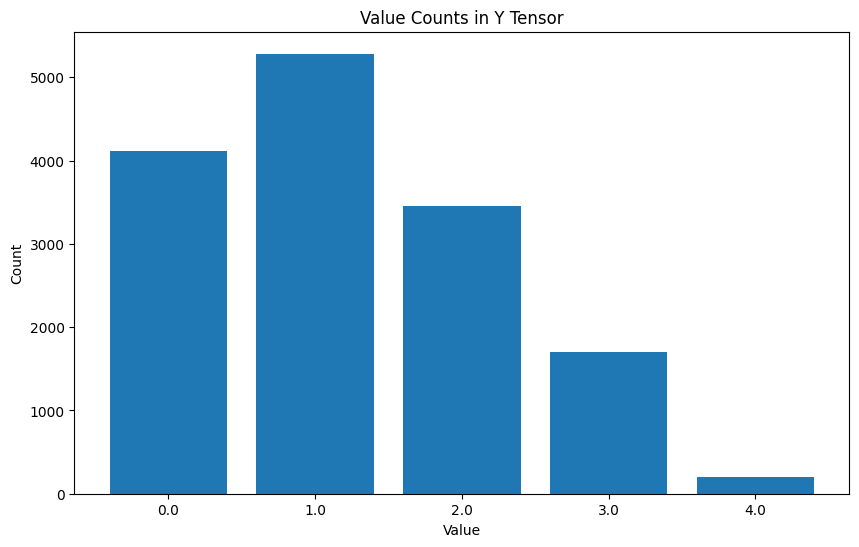

In [3]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data(num_intervals=4)


unique_values, counts = unique_value_counts(Y.sum(axis=1))
plot_unique_values_count(unique_values, counts, 'Value Counts in Y Tensor')

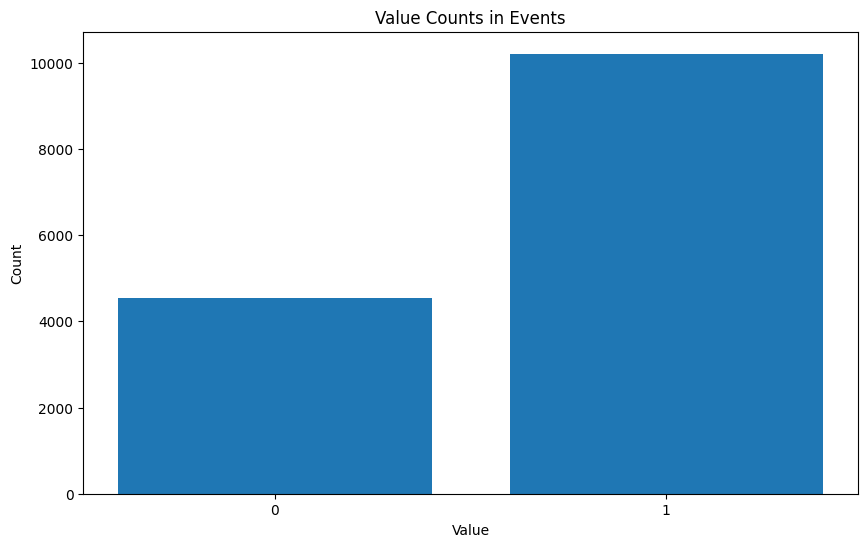

In [10]:

unique_values, counts = np.unique(event_all, return_counts=True)
plot_unique_values_count(unique_values, counts, 'Value Counts in Events')

Since the model without any regularization term yields almost the same c-index value, and considering that, based on your initial instructions, the data preprocessing and evaluation metrics implementations are correct, I believe there is no problem with the training process.

I suggest to use cross validation for better estimation of these mehods.

# Training model with no Regularization

In [2]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data(num_intervals=7)

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 5, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


no_reg_trainer = NoRegularizationTrainer(model,train_loader,test_loader,args)
no_reg_trainer.train()



  0%|          | 1/200 [00:02<08:36,  2.59s/it]

End of Epoch 0, Average Training Loss: 1.4539, Average Gradient Norm: 1.7781
End of Epoch 0, Average Validation Loss: 1.1112
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:03<05:53,  1.78s/it]

End of Epoch 1, Average Training Loss: 1.0967, Average Gradient Norm: 1.6711
End of Epoch 1, Average Validation Loss: 1.1427
Current Learning Rate: 0.010000


  2%|▏         | 3/200 [00:04<04:51,  1.48s/it]

End of Epoch 2, Average Training Loss: 1.0429, Average Gradient Norm: 1.6652
End of Epoch 2, Average Validation Loss: 1.1623
Current Learning Rate: 0.010000


  2%|▏         | 4/200 [00:06<04:30,  1.38s/it]

End of Epoch 3, Average Training Loss: 1.0361, Average Gradient Norm: 1.7492
End of Epoch 3, Average Validation Loss: 1.1805
Current Learning Rate: 0.010000
End of Epoch 4, Average Training Loss: 1.0365, Average Gradient Norm: 1.7253


  2%|▎         | 5/200 [00:07<04:35,  1.41s/it]

End of Epoch 4, Average Validation Loss: 1.1161
Current Learning Rate: 0.010000


  3%|▎         | 6/200 [00:08<04:22,  1.35s/it]

End of Epoch 5, Average Training Loss: 1.0313, Average Gradient Norm: 1.8633
End of Epoch 5, Average Validation Loss: 1.3488
Current Learning Rate: 0.010000


  4%|▎         | 7/200 [00:10<04:19,  1.34s/it]

End of Epoch 6, Average Training Loss: 1.0124, Average Gradient Norm: 1.7705
End of Epoch 6, Average Validation Loss: 1.3992
Current Learning Rate: 0.001000


  4%|▍         | 8/200 [00:11<04:15,  1.33s/it]

End of Epoch 7, Average Training Loss: 0.9701, Average Gradient Norm: 1.8370
End of Epoch 7, Average Validation Loss: 1.0884
Current Learning Rate: 0.001000
End of Epoch 8, Average Training Loss: 0.9406, Average Gradient Norm: 1.6659


  4%|▍         | 9/200 [00:12<04:22,  1.37s/it]

End of Epoch 8, Average Validation Loss: 1.0506
Current Learning Rate: 0.001000


  5%|▌         | 10/200 [00:14<04:19,  1.37s/it]

End of Epoch 9, Average Training Loss: 0.9262, Average Gradient Norm: 1.7186
End of Epoch 9, Average Validation Loss: 1.0689
Current Learning Rate: 0.001000


  6%|▌         | 11/200 [00:15<04:18,  1.37s/it]

End of Epoch 10, Average Training Loss: 0.9305, Average Gradient Norm: 1.8861
End of Epoch 10, Average Validation Loss: 1.0465
Current Learning Rate: 0.001000
End of Epoch 11, Average Training Loss: 0.9284, Average Gradient Norm: 1.8387


  6%|▌         | 12/200 [00:17<04:18,  1.37s/it]

End of Epoch 11, Average Validation Loss: 1.0795
Current Learning Rate: 0.001000


  6%|▋         | 13/200 [00:18<04:14,  1.36s/it]

End of Epoch 12, Average Training Loss: 0.9218, Average Gradient Norm: 1.9421
End of Epoch 12, Average Validation Loss: 1.0543
Current Learning Rate: 0.001000
End of Epoch 13, Average Training Loss: 0.9067, Average Gradient Norm: 1.9722


  7%|▋         | 14/200 [00:19<04:08,  1.34s/it]

End of Epoch 13, Average Validation Loss: 1.0508
Current Learning Rate: 0.001000


  8%|▊         | 15/200 [00:21<04:08,  1.35s/it]

End of Epoch 14, Average Training Loss: 0.9046, Average Gradient Norm: 1.9221
End of Epoch 14, Average Validation Loss: 1.0480
Current Learning Rate: 0.001000


  8%|▊         | 16/200 [00:22<04:03,  1.33s/it]

End of Epoch 15, Average Training Loss: 0.9084, Average Gradient Norm: 1.9306
End of Epoch 15, Average Validation Loss: 1.0279
Current Learning Rate: 0.001000


  8%|▊         | 17/200 [00:23<04:00,  1.32s/it]

End of Epoch 16, Average Training Loss: 0.9072, Average Gradient Norm: 2.0887
End of Epoch 16, Average Validation Loss: 1.0417
Current Learning Rate: 0.001000


  9%|▉         | 18/200 [00:24<04:01,  1.32s/it]

End of Epoch 17, Average Training Loss: 0.9025, Average Gradient Norm: 2.1396
End of Epoch 17, Average Validation Loss: 1.0857
Current Learning Rate: 0.001000


 10%|▉         | 19/200 [00:26<03:57,  1.31s/it]

End of Epoch 18, Average Training Loss: 0.9061, Average Gradient Norm: 2.2515
End of Epoch 18, Average Validation Loss: 1.0301
Current Learning Rate: 0.001000


 10%|█         | 20/200 [00:27<04:01,  1.34s/it]

End of Epoch 19, Average Training Loss: 0.8985, Average Gradient Norm: 2.2338
End of Epoch 19, Average Validation Loss: 1.0175
Current Learning Rate: 0.001000


 10%|█         | 21/200 [00:28<03:58,  1.33s/it]

End of Epoch 20, Average Training Loss: 0.8983, Average Gradient Norm: 2.2425
End of Epoch 20, Average Validation Loss: 1.1073
Current Learning Rate: 0.001000


 11%|█         | 22/200 [00:30<03:54,  1.32s/it]

End of Epoch 21, Average Training Loss: 0.8898, Average Gradient Norm: 2.2137
End of Epoch 21, Average Validation Loss: 1.0385
Current Learning Rate: 0.001000


 12%|█▏        | 23/200 [00:31<03:52,  1.31s/it]

End of Epoch 22, Average Training Loss: 0.8955, Average Gradient Norm: 2.2643
End of Epoch 22, Average Validation Loss: 1.1007
Current Learning Rate: 0.001000


 12%|█▏        | 24/200 [00:32<03:50,  1.31s/it]

End of Epoch 23, Average Training Loss: 0.8971, Average Gradient Norm: 2.1834
End of Epoch 23, Average Validation Loss: 1.0393
Current Learning Rate: 0.001000


 12%|█▎        | 25/200 [00:34<03:56,  1.35s/it]

End of Epoch 24, Average Training Loss: 0.8843, Average Gradient Norm: 2.3753
End of Epoch 24, Average Validation Loss: 1.1767
Current Learning Rate: 0.001000


 13%|█▎        | 26/200 [00:35<03:56,  1.36s/it]

End of Epoch 25, Average Training Loss: 0.8904, Average Gradient Norm: 2.2538
End of Epoch 25, Average Validation Loss: 1.1036
Current Learning Rate: 0.000100


 14%|█▎        | 27/200 [00:37<03:57,  1.37s/it]

End of Epoch 26, Average Training Loss: 0.8851, Average Gradient Norm: 2.2790
End of Epoch 26, Average Validation Loss: 1.0975
Current Learning Rate: 0.000100


 14%|█▍        | 28/200 [00:38<03:54,  1.36s/it]

End of Epoch 27, Average Training Loss: 0.8835, Average Gradient Norm: 2.3500
End of Epoch 27, Average Validation Loss: 1.0720
Current Learning Rate: 0.000100


 14%|█▍        | 29/200 [00:39<03:49,  1.34s/it]

End of Epoch 28, Average Training Loss: 0.8859, Average Gradient Norm: 2.2315
End of Epoch 28, Average Validation Loss: 1.1000
Current Learning Rate: 0.000100


 15%|█▌        | 30/200 [00:41<03:45,  1.33s/it]

End of Epoch 29, Average Training Loss: 0.8835, Average Gradient Norm: 2.2345
End of Epoch 29, Average Validation Loss: 1.0892
Current Learning Rate: 0.000100


 16%|█▌        | 31/200 [00:42<03:40,  1.31s/it]

End of Epoch 30, Average Training Loss: 0.8843, Average Gradient Norm: 2.2864
End of Epoch 30, Average Validation Loss: 1.0898
Current Learning Rate: 0.000100


 16%|█▌        | 32/200 [00:43<03:36,  1.29s/it]

End of Epoch 31, Average Training Loss: 0.8792, Average Gradient Norm: 2.2616
End of Epoch 31, Average Validation Loss: 1.0950
Current Learning Rate: 0.000010
End of Epoch 32, Average Training Loss: 0.8809, Average Gradient Norm: 2.2952
End of Epoch 32, Average Validation Loss: 1.0946
Current Learning Rate: 0.000010


 17%|█▋        | 34/200 [00:46<03:35,  1.30s/it]

End of Epoch 33, Average Training Loss: 0.8778, Average Gradient Norm: 2.2057
End of Epoch 33, Average Validation Loss: 1.0951
Current Learning Rate: 0.000010
End of Epoch 34, Average Training Loss: 0.8742, Average Gradient Norm: 2.2016


 17%|█▋        | 34/200 [00:47<03:52,  1.40s/it]

End of Epoch 34, Average Validation Loss: 1.0953
Current Learning Rate: 0.000010
Early stopping triggered after 35 epochs.


## Evaluating model with no regularization

In [3]:
no_reg_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

events, Y_true = true_values_from_data_loader(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)

predictions, Y_hat = no_reg_trainer.predict(train_loader)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

events, Y_true = true_values_from_data_loader(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)

predictions, Y_hat = no_reg_trainer.predict(test_loader)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")
# print(classification_report(Y_true_test.cpu(), Y_hat_test.cpu()))

Loaded model from checkpoint at epoch 20 with best validation loss 1.0175
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([3051, 3027, 1211, 1599, 1217,  669,  191,   43])
Y_hat Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([2644, 2471, 1150, 1153,  337,   68,   41, 3144])


100%|██████████| 11008/11008 [00:05<00:00, 1912.43it/s]


Train Data C-Index = 0.6662654876708984,  BScore = 0.4147600115040205

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([ 882,  783,  383,  414,  103,   22,   18, 1043])


100%|██████████| 3648/3648 [00:01<00:00, 1893.10it/s]


Test Data C-Index = 0.9793729782104492,  BScore = 0.06680446533862608


# Training model with Expected Gradient

In [13]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data()

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 1, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


eg_trainer = EGTrainer(model, train_loader, test_loader, train_dataset, args)
eg_trainer.train()





  0%|          | 1/200 [00:03<12:19,  3.72s/it]

End of Epoch 0, Average Training Loss: 2.1334, Average Gradient Norm: 2.6710
End of Epoch 0, Average Validation Loss: 1.5161
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:07<11:58,  3.63s/it]

End of Epoch 1, Average Training Loss: 1.7552, Average Gradient Norm: 3.7042
End of Epoch 1, Average Validation Loss: 1.3766
Current Learning Rate: 0.010000


  2%|▏         | 3/200 [00:10<11:40,  3.56s/it]

End of Epoch 2, Average Training Loss: 1.6918, Average Gradient Norm: 3.6522
End of Epoch 2, Average Validation Loss: 1.2554
Current Learning Rate: 0.010000
End of Epoch 3, Average Training Loss: 1.6532, Average Gradient Norm: 4.0869
End of Epoch 3, Average Validation Loss: 1.1053
Current Learning Rate: 0.010000


  2%|▎         | 5/200 [00:17<11:08,  3.43s/it]

End of Epoch 4, Average Training Loss: 1.6497, Average Gradient Norm: 3.8551
End of Epoch 4, Average Validation Loss: 1.1570
Current Learning Rate: 0.010000


  3%|▎         | 6/200 [00:20<11:00,  3.40s/it]

End of Epoch 5, Average Training Loss: 1.6811, Average Gradient Norm: 4.1058
End of Epoch 5, Average Validation Loss: 1.1187
Current Learning Rate: 0.010000


  4%|▎         | 7/200 [00:24<10:57,  3.40s/it]

End of Epoch 6, Average Training Loss: 1.6656, Average Gradient Norm: 4.6274
End of Epoch 6, Average Validation Loss: 1.1222
Current Learning Rate: 0.010000


  4%|▍         | 8/200 [00:27<10:54,  3.41s/it]

End of Epoch 7, Average Training Loss: 1.6532, Average Gradient Norm: 4.3619
End of Epoch 7, Average Validation Loss: 1.2831
Current Learning Rate: 0.010000


  4%|▍         | 9/200 [00:30<10:47,  3.39s/it]

End of Epoch 8, Average Training Loss: 1.6174, Average Gradient Norm: 4.0368
End of Epoch 8, Average Validation Loss: 1.1501
Current Learning Rate: 0.010000


  5%|▌         | 10/200 [00:34<10:41,  3.37s/it]

End of Epoch 9, Average Training Loss: 1.6396, Average Gradient Norm: 4.0744
End of Epoch 9, Average Validation Loss: 1.2308
Current Learning Rate: 0.001000


  6%|▌         | 11/200 [00:37<10:40,  3.39s/it]

End of Epoch 10, Average Training Loss: 1.5217, Average Gradient Norm: 3.6894
End of Epoch 10, Average Validation Loss: 1.0945
Current Learning Rate: 0.001000


  6%|▌         | 12/200 [00:41<10:35,  3.38s/it]

End of Epoch 11, Average Training Loss: 1.4908, Average Gradient Norm: 4.0372
End of Epoch 11, Average Validation Loss: 1.1035
Current Learning Rate: 0.001000
End of Epoch 12, Average Training Loss: 1.4826, Average Gradient Norm: 4.3743


  6%|▋         | 13/200 [00:44<10:35,  3.40s/it]

End of Epoch 12, Average Validation Loss: 1.0723
Current Learning Rate: 0.001000


  7%|▋         | 14/200 [00:47<10:31,  3.39s/it]

End of Epoch 13, Average Training Loss: 1.4738, Average Gradient Norm: 4.9336
End of Epoch 13, Average Validation Loss: 1.0688
Current Learning Rate: 0.001000


  8%|▊         | 15/200 [00:51<10:22,  3.37s/it]

End of Epoch 14, Average Training Loss: 1.4569, Average Gradient Norm: 4.8167
End of Epoch 14, Average Validation Loss: 1.0991
Current Learning Rate: 0.001000


  8%|▊         | 16/200 [00:54<10:24,  3.39s/it]

End of Epoch 15, Average Training Loss: 1.4741, Average Gradient Norm: 4.7675
End of Epoch 15, Average Validation Loss: 1.1007
Current Learning Rate: 0.001000


  8%|▊         | 17/200 [00:57<10:16,  3.37s/it]

End of Epoch 16, Average Training Loss: 1.4612, Average Gradient Norm: 4.8811
End of Epoch 16, Average Validation Loss: 1.0730
Current Learning Rate: 0.001000


  9%|▉         | 18/200 [01:01<10:14,  3.38s/it]

End of Epoch 17, Average Training Loss: 1.4628, Average Gradient Norm: 5.1104
End of Epoch 17, Average Validation Loss: 1.1097
Current Learning Rate: 0.001000


 10%|▉         | 19/200 [01:04<10:20,  3.43s/it]

End of Epoch 18, Average Training Loss: 1.4777, Average Gradient Norm: 5.5864
End of Epoch 18, Average Validation Loss: 1.0686
Current Learning Rate: 0.001000


 10%|█         | 20/200 [01:08<10:12,  3.40s/it]

End of Epoch 19, Average Training Loss: 1.4776, Average Gradient Norm: 5.3374
End of Epoch 19, Average Validation Loss: 1.1770
Current Learning Rate: 0.001000


 10%|█         | 21/200 [01:11<10:04,  3.38s/it]

End of Epoch 20, Average Training Loss: 1.4582, Average Gradient Norm: 5.3818
End of Epoch 20, Average Validation Loss: 1.1088
Current Learning Rate: 0.001000


 11%|█         | 22/200 [01:14<10:00,  3.37s/it]

End of Epoch 21, Average Training Loss: 1.4568, Average Gradient Norm: 5.4512
End of Epoch 21, Average Validation Loss: 1.0625
Current Learning Rate: 0.001000


 12%|█▏        | 23/200 [01:18<09:56,  3.37s/it]

End of Epoch 22, Average Training Loss: 1.4411, Average Gradient Norm: 5.8304
End of Epoch 22, Average Validation Loss: 1.0623
Current Learning Rate: 0.001000


 12%|█▏        | 24/200 [01:21<09:51,  3.36s/it]

End of Epoch 23, Average Training Loss: 1.4575, Average Gradient Norm: 6.0333
End of Epoch 23, Average Validation Loss: 1.1116
Current Learning Rate: 0.001000


 12%|█▎        | 25/200 [01:25<09:56,  3.41s/it]

End of Epoch 24, Average Training Loss: 1.4516, Average Gradient Norm: 5.8157
End of Epoch 24, Average Validation Loss: 1.0756
Current Learning Rate: 0.001000


 13%|█▎        | 26/200 [01:28<09:38,  3.32s/it]

End of Epoch 25, Average Training Loss: 1.4454, Average Gradient Norm: 6.0186
End of Epoch 25, Average Validation Loss: 1.0765
Current Learning Rate: 0.001000


 14%|█▎        | 27/200 [01:31<09:24,  3.26s/it]

End of Epoch 26, Average Training Loss: 1.4295, Average Gradient Norm: 6.1253
End of Epoch 26, Average Validation Loss: 1.1241
Current Learning Rate: 0.001000


 14%|█▍        | 28/200 [01:34<09:24,  3.28s/it]

End of Epoch 27, Average Training Loss: 1.4687, Average Gradient Norm: 6.1680
End of Epoch 27, Average Validation Loss: 1.0882
Current Learning Rate: 0.001000
End of Epoch 28, Average Training Loss: 1.4457, Average Gradient Norm: 6.0899


 14%|█▍        | 29/200 [01:39<10:51,  3.81s/it]

End of Epoch 28, Average Validation Loss: 1.0874
Current Learning Rate: 0.000100
End of Epoch 29, Average Training Loss: 1.4284, Average Gradient Norm: 5.9492


 15%|█▌        | 30/200 [01:47<13:48,  4.87s/it]

End of Epoch 29, Average Validation Loss: 1.0685
Current Learning Rate: 0.000100
End of Epoch 30, Average Training Loss: 1.4352, Average Gradient Norm: 6.0736


 16%|█▌        | 31/200 [01:54<15:39,  5.56s/it]

End of Epoch 30, Average Validation Loss: 1.0709
Current Learning Rate: 0.000100


 16%|█▌        | 32/200 [02:00<15:56,  5.69s/it]

End of Epoch 31, Average Training Loss: 1.4409, Average Gradient Norm: 5.7123
End of Epoch 31, Average Validation Loss: 1.0704
Current Learning Rate: 0.000100


 16%|█▋        | 33/200 [02:03<13:56,  5.01s/it]

End of Epoch 32, Average Training Loss: 1.4274, Average Gradient Norm: 5.6232
End of Epoch 32, Average Validation Loss: 1.0696
Current Learning Rate: 0.000100
End of Epoch 33, Average Training Loss: 1.4290, Average Gradient Norm: 6.1176


 17%|█▋        | 34/200 [02:09<14:10,  5.12s/it]

End of Epoch 33, Average Validation Loss: 1.0666
Current Learning Rate: 0.000100


 18%|█▊        | 35/200 [02:15<15:02,  5.47s/it]

End of Epoch 34, Average Training Loss: 1.4273, Average Gradient Norm: 5.7306
End of Epoch 34, Average Validation Loss: 1.0721
Current Learning Rate: 0.000010


 18%|█▊        | 36/200 [02:18<13:08,  4.81s/it]

End of Epoch 35, Average Training Loss: 1.4217, Average Gradient Norm: 5.9464
End of Epoch 35, Average Validation Loss: 1.0693
Current Learning Rate: 0.000010


 18%|█▊        | 37/200 [02:21<11:47,  4.34s/it]

End of Epoch 36, Average Training Loss: 1.4268, Average Gradient Norm: 6.0488
End of Epoch 36, Average Validation Loss: 1.0676
Current Learning Rate: 0.000010
End of Epoch 37, Average Training Loss: 1.4228, Average Gradient Norm: 6.2595


 18%|█▊        | 37/200 [02:25<10:39,  3.92s/it]

End of Epoch 37, Average Validation Loss: 1.0680
Current Learning Rate: 0.000010
Early stopping triggered after 38 epochs.


## Evaluating model with expected gradient

In [14]:
eg_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

events, Y_true = true_values_from_data_loader(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)

predictions, Y_hat = eg_trainer.predict(train_loader)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

events, Y_true = true_values_from_data_loader(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)

predictions, Y_hat = eg_trainer.predict(test_loader)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")
# print(classification_report(Y_true_test.cpu(), Y_hat_test.cpu()))
# 0.676588237285614,  BScore = 0.41820164413559596

Loaded model from checkpoint at epoch 23 with best validation loss 1.0623
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([3061, 3025, 1208, 1595, 1211,  673,  191,   44])
Y_hat Train
Unique Values: tensor([0., 1., 2., 3., 4., 7.])
Counts: tensor([2769, 2959, 1078,  730,  110, 3362])


100%|██████████| 11008/11008 [00:06<00:00, 1776.63it/s]


Train Data C-Index = 0.6810792088508606,  BScore = 0.41204649704763685

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0., 1., 2., 3., 4., 7.])
Counts: tensor([ 924,  969,  361,  239,   37, 1118])


100%|██████████| 3648/3648 [00:01<00:00, 1990.64it/s]


Test Data C-Index = 0.9757631421089172,  BScore = 0.06882471297958927


In [31]:
# Train Data C-Index = 0.6701002717018127,  BScore = 0.4229801690083058
# Test Data C-Index = 0.9794870018959045,  BScore = 0.06781598520763489

51719

# Training model with gradient attribution

In [6]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data()

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 5, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


g_trainer = GradientTrainer(model, train_loader, test_loader, args)
g_trainer.train()





  0%|          | 1/200 [00:02<09:21,  2.82s/it]

End of Epoch 0, Average Training Loss: 2.3919, Average Gradient Norm: 5.0477
End of Epoch 0, Average Validation Loss: 2.1042
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:05<08:39,  2.62s/it]

End of Epoch 1, Average Training Loss: 2.0109, Average Gradient Norm: 6.7016
End of Epoch 1, Average Validation Loss: 1.8651
Current Learning Rate: 0.010000


  2%|▏         | 3/200 [00:07<08:13,  2.51s/it]

End of Epoch 2, Average Training Loss: 1.9634, Average Gradient Norm: 7.7546
End of Epoch 2, Average Validation Loss: 1.9196
Current Learning Rate: 0.010000


  2%|▏         | 4/200 [00:10<08:05,  2.48s/it]

End of Epoch 3, Average Training Loss: 1.9519, Average Gradient Norm: 8.4646
End of Epoch 3, Average Validation Loss: 1.8335
Current Learning Rate: 0.010000


  2%|▎         | 5/200 [00:12<07:56,  2.45s/it]

End of Epoch 4, Average Training Loss: 1.9426, Average Gradient Norm: 8.7076
End of Epoch 4, Average Validation Loss: 1.8569
Current Learning Rate: 0.010000


  3%|▎         | 6/200 [00:14<07:55,  2.45s/it]

End of Epoch 5, Average Training Loss: 1.9460, Average Gradient Norm: 9.0900
End of Epoch 5, Average Validation Loss: 1.9520
Current Learning Rate: 0.010000


  4%|▎         | 7/200 [00:17<07:51,  2.44s/it]

End of Epoch 6, Average Training Loss: 1.9372, Average Gradient Norm: 9.4888
End of Epoch 6, Average Validation Loss: 1.8695
Current Learning Rate: 0.010000


  4%|▍         | 8/200 [00:19<07:55,  2.48s/it]

End of Epoch 7, Average Training Loss: 1.9169, Average Gradient Norm: 9.3942
End of Epoch 7, Average Validation Loss: 1.7694
Current Learning Rate: 0.010000


  4%|▍         | 9/200 [00:22<07:57,  2.50s/it]

End of Epoch 8, Average Training Loss: 1.9280, Average Gradient Norm: 9.6520
End of Epoch 8, Average Validation Loss: 1.8110
Current Learning Rate: 0.010000


  5%|▌         | 10/200 [00:24<07:55,  2.50s/it]

End of Epoch 9, Average Training Loss: 1.9328, Average Gradient Norm: 10.2025
End of Epoch 9, Average Validation Loss: 1.7713
Current Learning Rate: 0.010000


  6%|▌         | 11/200 [00:27<07:55,  2.51s/it]

End of Epoch 10, Average Training Loss: 1.9355, Average Gradient Norm: 9.5898
End of Epoch 10, Average Validation Loss: 1.8223
Current Learning Rate: 0.010000
End of Epoch 11, Average Training Loss: 1.9178, Average Gradient Norm: 9.8525


  6%|▌         | 12/200 [00:32<09:45,  3.12s/it]

End of Epoch 11, Average Validation Loss: 1.8880
Current Learning Rate: 0.010000
End of Epoch 12, Average Training Loss: 1.9068, Average Gradient Norm: 10.0844


  6%|▋         | 13/200 [00:37<11:43,  3.76s/it]

End of Epoch 12, Average Validation Loss: 1.7880
Current Learning Rate: 0.010000
End of Epoch 13, Average Training Loss: 1.9237, Average Gradient Norm: 10.8424


  7%|▋         | 14/200 [00:42<13:07,  4.23s/it]

End of Epoch 13, Average Validation Loss: 1.7902
Current Learning Rate: 0.001000
End of Epoch 14, Average Training Loss: 1.8099, Average Gradient Norm: 11.5374


  8%|▊         | 15/200 [00:47<14:02,  4.56s/it]

End of Epoch 14, Average Validation Loss: 1.7777
Current Learning Rate: 0.001000
End of Epoch 15, Average Training Loss: 1.7879, Average Gradient Norm: 13.4470


  8%|▊         | 16/200 [00:53<14:34,  4.75s/it]

End of Epoch 15, Average Validation Loss: 1.7967
Current Learning Rate: 0.001000
End of Epoch 16, Average Training Loss: 1.7775, Average Gradient Norm: 14.6801


  8%|▊         | 17/200 [00:58<14:56,  4.90s/it]

End of Epoch 16, Average Validation Loss: 1.7721
Current Learning Rate: 0.001000
End of Epoch 17, Average Training Loss: 1.7789, Average Gradient Norm: 16.5507


  9%|▉         | 18/200 [01:03<15:14,  5.02s/it]

End of Epoch 17, Average Validation Loss: 1.7806
Current Learning Rate: 0.001000
End of Epoch 18, Average Training Loss: 1.7702, Average Gradient Norm: 17.3683


 10%|▉         | 19/200 [01:07<14:05,  4.67s/it]

End of Epoch 18, Average Validation Loss: 1.7703
Current Learning Rate: 0.001000


 10%|█         | 20/200 [01:10<12:09,  4.05s/it]

End of Epoch 19, Average Training Loss: 1.7653, Average Gradient Norm: 18.5412
End of Epoch 19, Average Validation Loss: 1.7755
Current Learning Rate: 0.000100


 10%|█         | 21/200 [01:12<10:38,  3.57s/it]

End of Epoch 20, Average Training Loss: 1.7542, Average Gradient Norm: 17.0290
End of Epoch 20, Average Validation Loss: 1.7756
Current Learning Rate: 0.000100


 11%|█         | 22/200 [01:15<09:38,  3.25s/it]

End of Epoch 21, Average Training Loss: 1.7526, Average Gradient Norm: 18.9777
End of Epoch 21, Average Validation Loss: 1.7776
Current Learning Rate: 0.000100
End of Epoch 22, Average Training Loss: 1.7464, Average Gradient Norm: 18.6199


 11%|█         | 22/200 [01:18<10:38,  3.59s/it]

End of Epoch 22, Average Validation Loss: 1.7763
Current Learning Rate: 0.000100
Early stopping triggered after 23 epochs.


## Evaluating model with gradient attribution on test data


In [7]:
g_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

events, Y_true = true_values_from_data_loader(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)

predictions, Y_hat = g_trainer.predict(train_loader)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

events, Y_true = true_values_from_data_loader(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)

predictions, Y_hat = g_trainer.predict(test_loader)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")
# print(classification_report(Y_true_test.cpu(), Y_hat_test.cpu()))

Loaded model from checkpoint at epoch 8 with best validation loss 1.7694
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([3062, 3019, 1205, 1599, 1215,  673,  191,   44])
Y_hat Train
Unique Values: tensor([0., 1., 2., 3., 4.])
Counts: tensor([5485,    1,   87, 2269, 3166])


100%|██████████| 11008/11008 [00:05<00:00, 1934.79it/s]


Train Data C-Index = 0.7358831763267517,  BScore = 0.27393871919404544

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0., 2., 3., 4.])
Counts: tensor([1806,   36,  768, 1038])


100%|██████████| 3648/3648 [00:01<00:00, 2214.94it/s]


Test Data C-Index = 0.9825875759124756,  BScore = 0.13928659180096212
